### Import library and model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
import random

### Import, Scale and Split Dataset

In [2]:
# Import Dataset
 # EUR - VND
eur = pd.read_csv('..\Dataset\EUR.csv')
 # GBP - VND
gbp = pd.read_csv("..\Dataset\GBP.csv")
 # JPY - VND
jpy = pd.read_csv("..\Dataset\JPY.csv")
# Convert
eur = eur['Sale'].replace({',':''}, regex=True).astype(float)
gbp = gbp['Sale'].replace({',':''}, regex=True).astype(float)
jpy = jpy['Sale'].replace({',':''}, regex=True).astype(float)

### MinMaxScaler

In [3]:
# Scaler model
scaler=MinMaxScaler(feature_range=(0,1))

### Standardizate function

In [4]:
# Function to standardizate the data
def standardizate_data(train, test, pre_test, f3, f6, f9):
    # Train
    train = np.reshape(train, (-1,1))
    train1 = scaler.inverse_transform(train)
    # Test
    test = np.reshape(test, (-1,1))
    test1 = scaler.inverse_transform(test)
    # Test prediction
    pre_test = np.reshape(pre_test, (-1,1))
    pre_test1 = scaler.inverse_transform(pre_test)
    # Forecast 30
    f3 = np.reshape(f3, (-1,1))
    f3_tf= scaler.inverse_transform(f3)
    # Forecast 60
    f6 = np.reshape(f6, (-1,1))
    f6_tf= scaler.inverse_transform(f6)
    # Forecast 90
    f9 = np.reshape(f9, (-1,1))
    f9_tf= scaler.inverse_transform(f9)
    
    return train1, test1, pre_test1, f3_tf, f6_tf, f9_tf 

### Prepare data

In [5]:
# Function to convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

### Forecast

In [19]:
# Function to forecast next 30, 60, 90 days data
def forecast_days(model, test, time_step):
    x_input = test[len(test)-time_step:].reshape(1,-1)

    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()

    forecast30 = []
    forecast60 = []
    forecast90 = []
    n_steps=time_step
    i=0
    while(i<=90):
        if(len(temp_input)>time_step):
            x_input=np.array(temp_input[1:])
            print("{} day input {}".format(i,x_input))
            x_input = x_input.reshape(1,-1)
            yhat = model.predict(x_input, verbose=0)
            print("{} day output {}".format(i,yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            if i <= 30:
                forecast30.extend(yhat.tolist())
            elif i <= 60:
                forecast60.extend(yhat.tolist())
            else:
                forecast90.extend(yhat.tolist())
            i=i+1
        else:
            yhat = model.predict(x_input, verbose=0)
            print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            print(len(temp_input))
            forecast30.extend(yhat.tolist())
            i=i+1
    return forecast30, forecast60, forecast90

### Visualize

In [12]:
# Function to visualize the model
def visualize_MLP(model, train, test, pre_test, f3, f6, f9, time_step):
    # set index
    # set train, test index
    index = pd.date_range(start='3/1/2019', end='6/1/2024', freq='d')
    # set forecast index
    forecast_index = pd.date_range(start='6/1/2024', periods=91, freq='d')
    
    # Visualize
    plt.figure(figsize=(12, 6))
    plt.plot(index[:len(train)], scaler.inverse_transform(train))
    plt.plot(index[len(train):], scaler.inverse_transform(test))
    plt.plot(index[len(train)+time_step:],scaler.inverse_transform(pre_test))
    plt.plot(forecast_index[:31], scaler.inverse_transform(f3))
    plt.plot(forecast_index[31:61], scaler.inverse_transform(f6))
    plt.plot(forecast_index[61:], scaler.inverse_transform(f9))
    plt.title('MLP Time Series Forecast')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate (VND)')
    plt.legend(['Train','Test','TestPred','Forecast 30 days next','Forecast 60 days next','Forecast 90 days next'])
    plt.show()

### Evaluate

In [13]:
# Function to evaluate the model
def evaluate(forecast, actual):
    forecast = np.array(forecast)
    actual = np.array(actual)
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))*100  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE

    print('RMSE =',rmse)
    print('MAPE(%) =',mape)
    print('MAE =',mae)

### Set seed

- Ensure that your model is always initialized and trained with the same random seed (đảm bảo rằng mô hình của bạn sẽ luôn được khởi tạo và huấn luyện với cùng một chuỗi số ngẫu nhiên => cùng một kết quả mỗi khi chạy lại chương trình)

- Ensure that differences in results are not due to differences in random numbers but rather due to differences in the nature of the models. (đảm bảo rằng sự khác biệt trong kết quả không phải do sự khác biệt trong số ngẫu nhiên mà do sự khác biệt trong bản chất của các mô hình)

### Implement

In [44]:
def implement_MLP(train, test):
    # set seed
    np.random.seed(0)
    tf.random.set_seed(0)
    random.seed(0)
    
    # Time step
    time_step = 20 #20
    
    # Convert train and test data
    X_train, y_train = create_dataset(train, time_step)
    X_test, y_test = create_dataset(test, time_step)
    
    # Define MLP model
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=time_step))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    # Fit model
    model.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=100, batch_size=64, verbose=0)
    
    # Predict test data
    pre_test = model.predict(X_test)
    
    # Forecast next 30, 60, 90 days
    forecast30, forecast60, forecast90 = forecast_days(model, test, time_step)
    
    # Visualize model
    visualize_MLP(model, train, test, pre_test, forecast30, forecast60, forecast90, time_step)

    # Standardizate
    train, test, pre_test, forecast30, forecast60, forecast90 = standardizate_data(train, test, pre_test, forecast30, forecast60, forecast90)

    # Measure accurancy
    evaluate(pre_test, test[time_step:])

# EUR - VND


In [40]:
# Scale data
eur_sc = scaler.fit_transform(np.array(eur).reshape(-1,1))
# Split train, test data
 ## case 1. 7:3
train_eur_1_sc = eur_sc[:int(0.7*len(eur))]
test_eur_1_sc = eur_sc[int(0.7*len(eur)):]
 ## case 2. 8:2
train_eur_2_sc = eur_sc[:int(0.8*len(eur))]
test_eur_2_sc = eur_sc[int(0.8*len(eur)):]
 ## case 3. 9:1
train_eur_3_sc = eur_sc[:int(0.9*len(eur))]
test_eur_3_sc = eur_sc[int(0.9*len(eur)):]

- **Case 1. 7:3**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[0.8624235]
21
1 day input [0.84487338 0.86116522 0.87745706 0.86895697 0.86895697 0.86895697
 0.88153002 0.87515495 0.87497786 0.87090491 0.86187356 0.86187356
 0.86187356 0.87267576 0.87975916 0.87267576 0.85567558 0.86683195
 0.86683195 0.86242348]
1 day output [[0.85939014]]
2 day input [0.86116522 0.87745706 0.86895697 0.86895697 0.86895697 0.88153002
 0.87515495 0.87497786 0.87090491 0.86187356 0.86187356 0.86187356
 0.87267576 0.87975916 0.87267576 0.85567558 0.86683195 0.86683195
 0.86242348 0.85939014]
2 day output [[0.854784]]
3 day input [0.87745706 0.86895697 0.86895697 0.86895697 0.88153002 0.87515495
 0.87497786 0.87090491 0.86187356 0.86187356 0.86187356 0.87267576
 0.87975916 0.87267576 0.85567558 0.86683195 0.86683195 0.86242348
 0.85939014 0.85478401]
3 day output [[0.8488981]]
4 day input [0.86895697 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786
 0.87090491 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916
 0.8726

33 day output [[0.74130255]]
34 day input [0.80233526 0.79970479 0.79681152 0.7924636  0.78906614 0.7861622
 0.78272259 0.77962065 0.77671617 0.77337819 0.76978463 0.76691794
 0.76392686 0.76052791 0.75726599 0.75412315 0.75085884 0.74758619
 0.74454492 0.74130255]
34 day output [[0.7379778]]
35 day input [0.79970479 0.79681152 0.7924636  0.78906614 0.7861622  0.78272259
 0.77962065 0.77671617 0.77337819 0.76978463 0.76691794 0.76392686
 0.76052791 0.75726599 0.75412315 0.75085884 0.74758619 0.74454492
 0.74130255 0.7379778 ]
35 day output [[0.73481554]]
36 day input [0.79681152 0.7924636  0.78906614 0.7861622  0.78272259 0.77962065
 0.77671617 0.77337819 0.76978463 0.76691794 0.76392686 0.76052791
 0.75726599 0.75412315 0.75085884 0.74758619 0.74454492 0.74130255
 0.7379778  0.73481554]
36 day output [[0.731734]]
37 day input [0.7924636  0.78906614 0.7861622  0.78272259 0.77962065 0.77671617
 0.77337819 0.76978463 0.76691794 0.76392686 0.76052791 0.75726599
 0.75412315 0.75085884 0.74

65 day output [[0.6470549]]
66 day input [0.70102757 0.6980508  0.69509459 0.69217247 0.68924922 0.68632531
 0.68344432 0.68057668 0.67770118 0.67484516 0.67201316 0.66918606
 0.66636902 0.66357589 0.66079015 0.65801138 0.65525293 0.65251118
 0.64977646 0.64705491]
66 day output [[0.6443515]]
67 day input [0.6980508  0.69509459 0.69217247 0.68924922 0.68632531 0.68344432
 0.68057668 0.67770118 0.67484516 0.67201316 0.66918606 0.66636902
 0.66357589 0.66079015 0.65801138 0.65525293 0.65251118 0.64977646
 0.64705491 0.64435148]
67 day output [[0.6416584]]
68 day input [0.69509459 0.69217247 0.68924922 0.68632531 0.68344432 0.68057668
 0.67770118 0.67484516 0.67201316 0.66918606 0.66636902 0.66357589
 0.66079015 0.65801138 0.65525293 0.65251118 0.64977646 0.64705491
 0.64435148 0.64165843]
68 day output [[0.6389776]]
69 day input [0.69217247 0.68924922 0.68632531 0.68344432 0.68057668 0.67770118
 0.67484516 0.67201316 0.66918606 0.66636902 0.66357589 0.66079015
 0.65801138 0.65525293 0.65

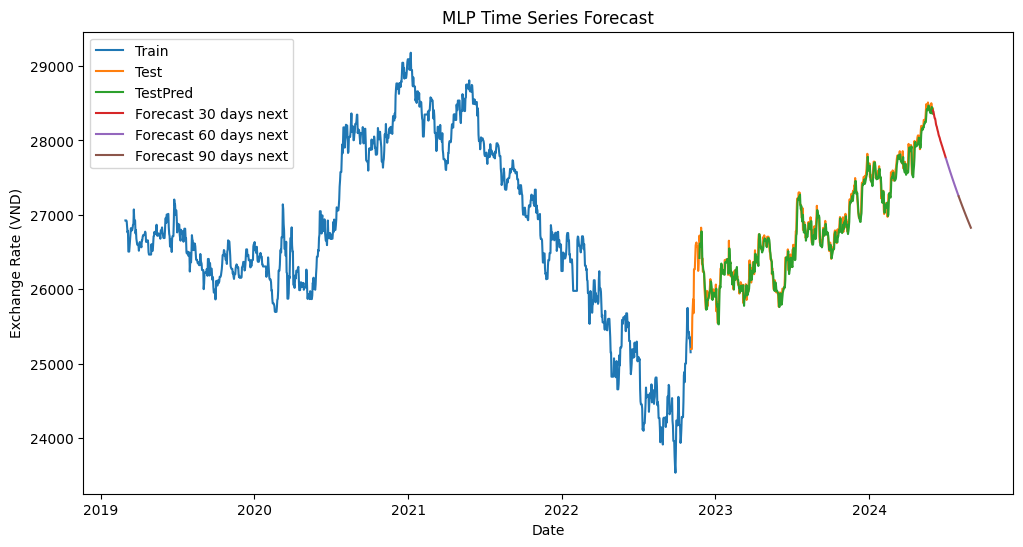

RMSE = 101.66998055505036
MAPE(%) = 0.2762892891612992
MAE = 74.1455675303508


In [45]:
implement_MLP(train_eur_1_sc, test_eur_1_sc)

- **Case 2. 8:2**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[0.8702725]
21
1 day input [0.84487338 0.86116522 0.87745706 0.86895697 0.86895697 0.86895697
 0.88153002 0.87515495 0.87497786 0.87090491 0.86187356 0.86187356
 0.86187356 0.87267576 0.87975916 0.87267576 0.85567558 0.86683195
 0.86683195 0.87027252]
1 day output [[0.87548274]]
2 day input [0.86116522 0.87745706 0.86895697 0.86895697 0.86895697 0.88153002
 0.87515495 0.87497786 0.87090491 0.86187356 0.86187356 0.86187356
 0.87267576 0.87975916 0.87267576 0.85567558 0.86683195 0.86683195
 0.87027252 0.87548274]
2 day output [[0.87757736]]
3 day input [0.87745706 0.86895697 0.86895697 0.86895697 0.88153002 0.87515495
 0.87497786 0.87090491 0.86187356 0.86187356 0.86187356 0.87267576
 0.87975916 0.87267576 0.85567558 0.86683195 0.86683195 0.87027252
 0.87548274 0.87757736]
3 day output [[0.87947464]]
4 day input [0.86895697 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786
 0.87090491 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916
 0.8

32 day output [[0.9548225]]
33 day input [0.90812677 0.91050738 0.91137522 0.91460878 0.9169178  0.91916221
 0.92166483 0.92401743 0.92653501 0.92882562 0.93165386 0.93424141
 0.93677926 0.93921793 0.94187784 0.94450128 0.9470247  0.94969559
 0.9521994  0.95482248]
33 day output [[0.95726156]]
34 day input [0.91050738 0.91137522 0.91460878 0.9169178  0.91916221 0.92166483
 0.92401743 0.92653501 0.92882562 0.93165386 0.93424141 0.93677926
 0.93921793 0.94187784 0.94450128 0.9470247  0.94969559 0.9521994
 0.95482248 0.95726156]
34 day output [[0.95990574]]
35 day input [0.91137522 0.91460878 0.9169178  0.91916221 0.92166483 0.92401743
 0.92653501 0.92882562 0.93165386 0.93424141 0.93677926 0.93921793
 0.94187784 0.94450128 0.9470247  0.94969559 0.9521994  0.95482248
 0.95726156 0.95990574]
35 day output [[0.96247977]]
36 day input [0.91460878 0.9169178  0.91916221 0.92166483 0.92401743 0.92653501
 0.92882562 0.93165386 0.93424141 0.93677926 0.93921793 0.94187784
 0.94450128 0.9470247  0.

66 day output [[1.0448431]]
67 day input [0.99371511 0.99637395 0.99901515 1.00168049 1.00432944 1.00700104
 1.00967216 1.01234341 1.01502347 1.01770544 1.02039826 1.02308846
 1.02579153 1.02849531 1.03120697 1.03392172 1.03664362 1.03937244
 1.04210341 1.04484308]
67 day output [[1.0475854]]
68 day input [0.99637395 0.99901515 1.00168049 1.00432944 1.00700104 1.00967216
 1.01234341 1.01502347 1.01770544 1.02039826 1.02308846 1.02579153
 1.02849531 1.03120697 1.03392172 1.03664362 1.03937244 1.04210341
 1.04484308 1.04758537]
68 day output [[1.0503358]]
69 day input [0.99901515 1.00168049 1.00432944 1.00700104 1.00967216 1.01234341
 1.01502347 1.01770544 1.02039826 1.02308846 1.02579153 1.02849531
 1.03120697 1.03392172 1.03664362 1.03937244 1.04210341 1.04484308
 1.04758537 1.05033576]
69 day output [[1.053089]]
70 day input [1.00168049 1.00432944 1.00700104 1.00967216 1.01234341 1.01502347
 1.01770544 1.02039826 1.02308846 1.02579153 1.02849531 1.03120697
 1.03392172 1.03664362 1.039

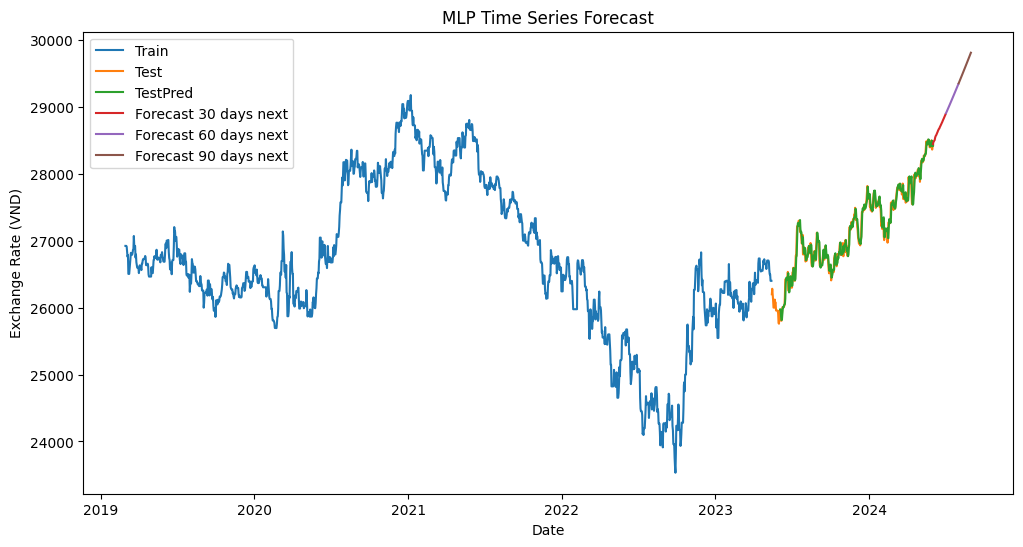

RMSE = 90.74615932239031
MAPE(%) = 0.24302161114399087
MAE = 65.97992681146995


In [46]:
implement_MLP(train_eur_2_sc, test_eur_2_sc)

- **Case 3. 9:1**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[0.86745]
21
1 day input [0.84487338 0.86116522 0.87745706 0.86895697 0.86895697 0.86895697
 0.88153002 0.87515495 0.87497786 0.87090491 0.86187356 0.86187356
 0.86187356 0.87267576 0.87975916 0.87267576 0.85567558 0.86683195
 0.86683195 0.86745   ]
1 day output [[0.86904484]]
2 day input [0.86116522 0.87745706 0.86895697 0.86895697 0.86895697 0.88153002
 0.87515495 0.87497786 0.87090491 0.86187356 0.86187356 0.86187356
 0.87267576 0.87975916 0.87267576 0.85567558 0.86683195 0.86683195
 0.86745    0.86904484]
2 day output [[0.8679521]]
3 day input [0.87745706 0.86895697 0.86895697 0.86895697 0.88153002 0.87515495
 0.87497786 0.87090491 0.86187356 0.86187356 0.86187356 0.87267576
 0.87975916 0.87267576 0.85567558 0.86683195 0.86683195 0.86745
 0.86904484 0.86795211]
3 day output [[0.86677355]]
4 day input [0.86895697 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786
 0.87090491 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916
 0.87267576 

32 day output [[0.8620698]]
33 day input [0.86544675 0.86553395 0.86428976 0.86477894 0.86488229 0.86450678
 0.86434036 0.86402714 0.86399072 0.86374807 0.86365223 0.86358565
 0.86329329 0.86305583 0.86289537 0.86281043 0.86257368 0.86245328
 0.8621946  0.86206979]
33 day output [[0.8618486]]
34 day input [0.86553395 0.86428976 0.86477894 0.86488229 0.86450678 0.86434036
 0.86402714 0.86399072 0.86374807 0.86365223 0.86358565 0.86329329
 0.86305583 0.86289537 0.86281043 0.86257368 0.86245328 0.8621946
 0.86206979 0.86184859]
34 day output [[0.86169165]]
35 day input [0.86428976 0.86477894 0.86488229 0.86450678 0.86434036 0.86402714
 0.86399072 0.86374807 0.86365223 0.86358565 0.86329329 0.86305583
 0.86289537 0.86281043 0.86257368 0.86245328 0.8621946  0.86206979
 0.86184859 0.86169165]
35 day output [[0.86155397]]
36 day input [0.86477894 0.86488229 0.86450678 0.86434036 0.86402714 0.86399072
 0.86374807 0.86365223 0.86358565 0.86329329 0.86305583 0.86289537
 0.86281043 0.86257368 0.8

66 day output [[0.8563954]]
67 day input [0.85949314 0.85933131 0.85915852 0.85899568 0.85882998 0.85866249
 0.85850114 0.85833412 0.85817057 0.85800672 0.85784429 0.85768223
 0.85751915 0.85735792 0.85719585 0.8570357  0.85687423 0.85671526
 0.85655469 0.85639542]
67 day output [[0.8562362]]
68 day input [0.85933131 0.85915852 0.85899568 0.85882998 0.85866249 0.85850114
 0.85833412 0.85817057 0.85800672 0.85784429 0.85768223 0.85751915
 0.85735792 0.85719585 0.8570357  0.85687423 0.85671526 0.85655469
 0.85639542 0.85623622]
68 day output [[0.85607743]]
69 day input [0.85915852 0.85899568 0.85882998 0.85866249 0.85850114 0.85833412
 0.85817057 0.85800672 0.85784429 0.85768223 0.85751915 0.85735792
 0.85719585 0.8570357  0.85687423 0.85671526 0.85655469 0.85639542
 0.85623622 0.85607743]
69 day output [[0.8559196]]
70 day input [0.85899568 0.85882998 0.85866249 0.85850114 0.85833412 0.85817057
 0.85800672 0.85784429 0.85768223 0.85751915 0.85735792 0.85719585
 0.8570357  0.85687423 0.8

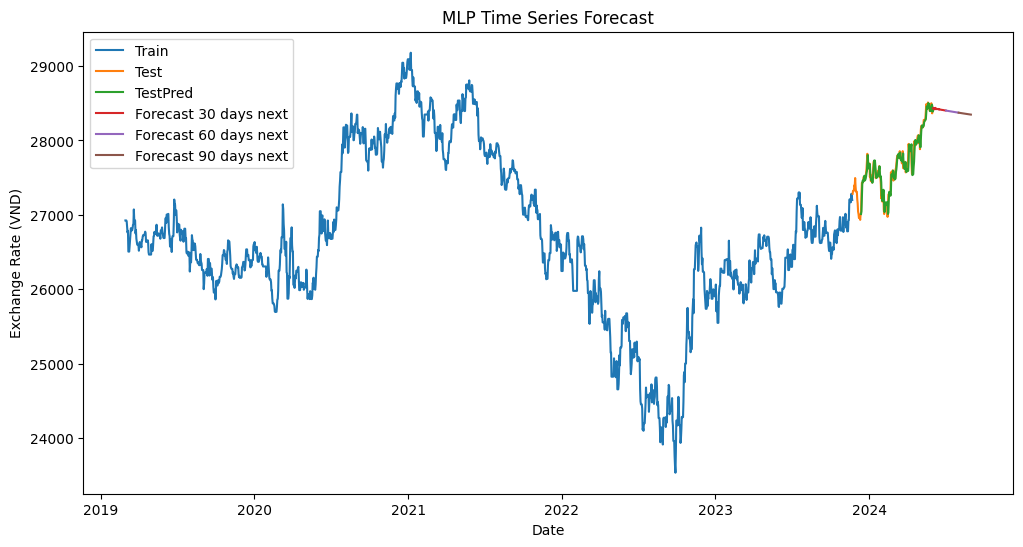

RMSE = 84.83348106621767
MAPE(%) = 0.21428358860593033
MAE = 59.27083711845935


In [47]:
implement_MLP(train_eur_3_sc, test_eur_3_sc)

# GBP - VND

In [49]:
# Scale data
gbp_sc = scaler.fit_transform(np.array(gbp).reshape(-1,1))
# Split train, test data
 ## case 1. 7:3
train_gbp_1_sc = gbp_sc[:int(0.7*len(gbp))]
test_gbp_1_sc = gbp_sc[int(0.7*len(gbp)):]
 ## case 2. 8:2
train_gbp_2_sc = gbp_sc[:int(0.8*len(gbp))]
test_gbp_2_sc = gbp_sc[int(0.8*len(gbp)):]
 ## case 3. 9:1
train_gbp_3_sc = gbp_sc[:int(0.9*len(gbp))]
test_gbp_3_sc = gbp_sc[int(0.9*len(gbp)):]

- **Case 1. 7:3**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[0.954157]
21
1 day input [0.91004641 0.93147693 0.95345345 0.94840295 0.94840295 0.94840295
 0.96573847 0.97078897 0.97215397 0.97734098 0.97010647 0.97010647
 0.97010647 0.98321048 0.98948949 0.98826099 0.97229047 0.97147147
 0.97147147 0.95415699]
1 day output [[0.94446784]]
2 day input [0.93147693 0.95345345 0.94840295 0.94840295 0.94840295 0.96573847
 0.97078897 0.97215397 0.97734098 0.97010647 0.97010647 0.97010647
 0.98321048 0.98948949 0.98826099 0.97229047 0.97147147 0.97147147
 0.95415699 0.94446784]
2 day output [[0.9295242]]
3 day input [0.95345345 0.94840295 0.94840295 0.94840295 0.96573847 0.97078897
 0.97215397 0.97734098 0.97010647 0.97010647 0.97010647 0.98321048
 0.98948949 0.98826099 0.97229047 0.97147147 0.97147147 0.95415699
 0.94446784 0.92952418]
3 day output [[0.91905224]]
4 day input [0.94840295 0.94840295 0.94840295 0.96573847 0.97078897 0.97215397
 0.97734098 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949
 0.988

32 day output [[0.59414065]]
33 day input [0.78609961 0.77579689 0.76302171 0.75183856 0.73996097 0.72800624
 0.71779352 0.70687699 0.69719636 0.68599159 0.67606294 0.66598105
 0.65678048 0.6472137  0.63773954 0.62855142 0.61950147 0.61102676
 0.60226172 0.59414065]
33 day output [[0.5854556]]
34 day input [0.77579689 0.76302171 0.75183856 0.73996097 0.72800624 0.71779352
 0.70687699 0.69719636 0.68599159 0.67606294 0.66598105 0.65678048
 0.6472137  0.63773954 0.62855142 0.61950147 0.61102676 0.60226172
 0.59414065 0.5854556 ]
34 day output [[0.57754433]]
35 day input [0.76302171 0.75183856 0.73996097 0.72800624 0.71779352 0.70687699
 0.69719636 0.68599159 0.67606294 0.66598105 0.65678048 0.6472137
 0.63773954 0.62855142 0.61950147 0.61102676 0.60226172 0.59414065
 0.5854556  0.57754433]
35 day output [[0.569525]]
36 day input [0.75183856 0.73996097 0.72800624 0.71779352 0.70687699 0.69719636
 0.68599159 0.67606294 0.66598105 0.65678048 0.6472137  0.63773954
 0.62855142 0.61950147 0.61

63 day output [[0.39354512]]
64 day input [0.50367069 0.49700531 0.49041197 0.48392814 0.47754636 0.47118551
 0.46507639 0.45894805 0.4530564  0.44711208 0.44135708 0.43565577
 0.43008086 0.42461532 0.41918778 0.41390014 0.40864289 0.40354714
 0.39848354 0.39354512]
64 day output [[0.38864663]]
65 day input [0.49700531 0.49041197 0.48392814 0.47754636 0.47118551 0.46507639
 0.45894805 0.4530564  0.44711208 0.44135708 0.43565577 0.43008086
 0.42461532 0.41918778 0.41390014 0.40864289 0.40354714 0.39848354
 0.39354512 0.38864663]
65 day output [[0.38385588]]
66 day input [0.49041197 0.48392814 0.47754636 0.47118551 0.46507639 0.45894805
 0.4530564  0.44711208 0.44135708 0.43565577 0.43008086 0.42461532
 0.41918778 0.41390014 0.40864289 0.40354714 0.39848354 0.39354512
 0.38864663 0.38385588]
66 day output [[0.37914297]]
67 day input [0.48392814 0.47754636 0.47118551 0.46507639 0.45894805 0.4530564
 0.44711208 0.44135708 0.43565577 0.43008086 0.42461532 0.41918778
 0.41390014 0.40864289 0

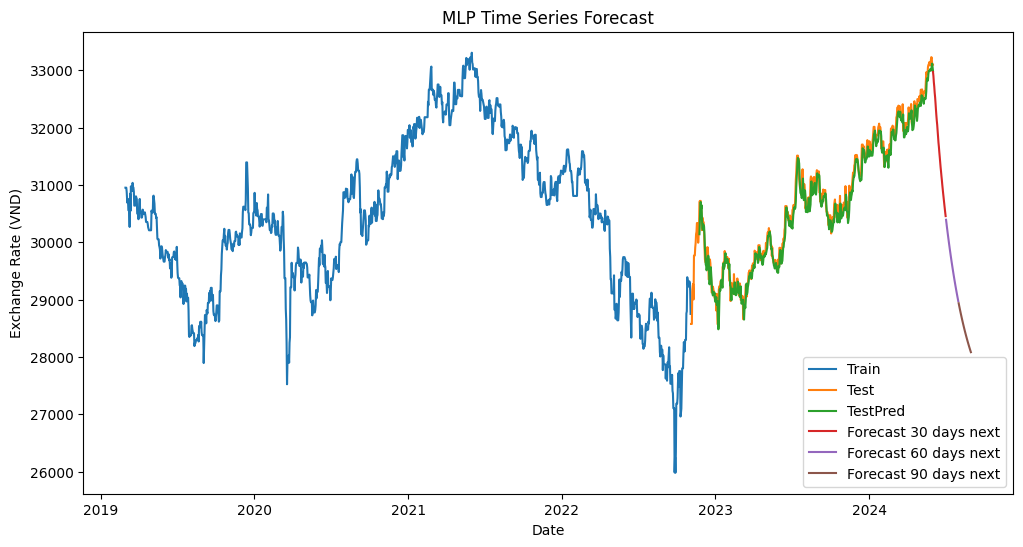

RMSE = 154.241926583053
MAPE(%) = 0.396546834013321
MAE = 122.14024912882195


In [50]:
implement_MLP(train_gbp_1_sc, test_gbp_1_sc)

- **Case 2. 8:2**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[0.97771305]
21
1 day input [0.91004641 0.93147693 0.95345345 0.94840295 0.94840295 0.94840295
 0.96573847 0.97078897 0.97215397 0.97734098 0.97010647 0.97010647
 0.97010647 0.98321048 0.98948949 0.98826099 0.97229047 0.97147147
 0.97147147 0.97771305]
1 day output [[0.9836474]]
2 day input [0.93147693 0.95345345 0.94840295 0.94840295 0.94840295 0.96573847
 0.97078897 0.97215397 0.97734098 0.97010647 0.97010647 0.97010647
 0.98321048 0.98948949 0.98826099 0.97229047 0.97147147 0.97147147
 0.97771305 0.98364741]
2 day output [[0.98889977]]
3 day input [0.95345345 0.94840295 0.94840295 0.94840295 0.96573847 0.97078897
 0.97215397 0.97734098 0.97010647 0.97010647 0.97010647 0.98321048
 0.98948949 0.98826099 0.97229047 0.97147147 0.97147147 0.97771305
 0.98364741 0.98889977]
3 day output [[0.9972062]]
4 day input [0.94840295 0.94840295 0.94840295 0.96573847 0.97078897 0.97215397
 0.97734098 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949
 0.98

33 day output [[1.2307105]]
34 day input [1.08008444 1.08733797 1.09619582 1.10347295 1.11130714 1.11882353
 1.12660432 1.13496327 1.14224672 1.1502521  1.15765858 1.16603732
 1.17405355 1.18211079 1.1900115  1.19790995 1.20612872 1.21424687
 1.22267187 1.23071051]
34 day output [[1.2390888]]
35 day input [1.08733797 1.09619582 1.10347295 1.11130714 1.11882353 1.12660432
 1.13496327 1.14224672 1.1502521  1.15765858 1.16603732 1.17405355
 1.18211079 1.1900115  1.19790995 1.20612872 1.21424687 1.22267187
 1.23071051 1.23908877]
35 day output [[1.247275]]
36 day input [1.09619582 1.10347295 1.11130714 1.11882353 1.12660432 1.13496327
 1.14224672 1.1502521  1.15765858 1.16603732 1.17405355 1.18211079
 1.1900115  1.19790995 1.20612872 1.21424687 1.22267187 1.23071051
 1.23908877 1.24727499]
36 day output [[1.2557862]]
37 day input [1.10347295 1.11130714 1.11882353 1.12660432 1.13496327 1.14224672
 1.1502521  1.15765858 1.16603732 1.17405355 1.18211079 1.1900115
 1.19790995 1.20612872 1.2142

68 day output [[1.5462899]]
69 day input [1.36830759 1.37729335 1.38626301 1.39535928 1.4044205  1.41357648
 1.42273712 1.43196845 1.44125307 1.45055962 1.459939   1.4693228
 1.47879565 1.48828423 1.49784636 1.50743353 1.51707518 1.52676439
 1.53649724 1.54628992]
69 day output [[1.5561131]]
70 day input [1.37729335 1.38626301 1.39535928 1.4044205  1.41357648 1.42273712
 1.43196845 1.44125307 1.45055962 1.459939   1.4693228  1.47879565
 1.48828423 1.49784636 1.50743353 1.51707518 1.52676439 1.53649724
 1.54628992 1.55611312]
70 day output [[1.5660008]]
71 day input [1.38626301 1.39535928 1.4044205  1.41357648 1.42273712 1.43196845
 1.44125307 1.45055962 1.459939   1.4693228  1.47879565 1.48828423
 1.49784636 1.50743353 1.51707518 1.52676439 1.53649724 1.54628992
 1.55611312 1.56600082]
71 day output [[1.57592]]
72 day input [1.39535928 1.4044205  1.41357648 1.42273712 1.43196845 1.44125307
 1.45055962 1.459939   1.4693228  1.47879565 1.48828423 1.49784636
 1.50743353 1.51707518 1.52676

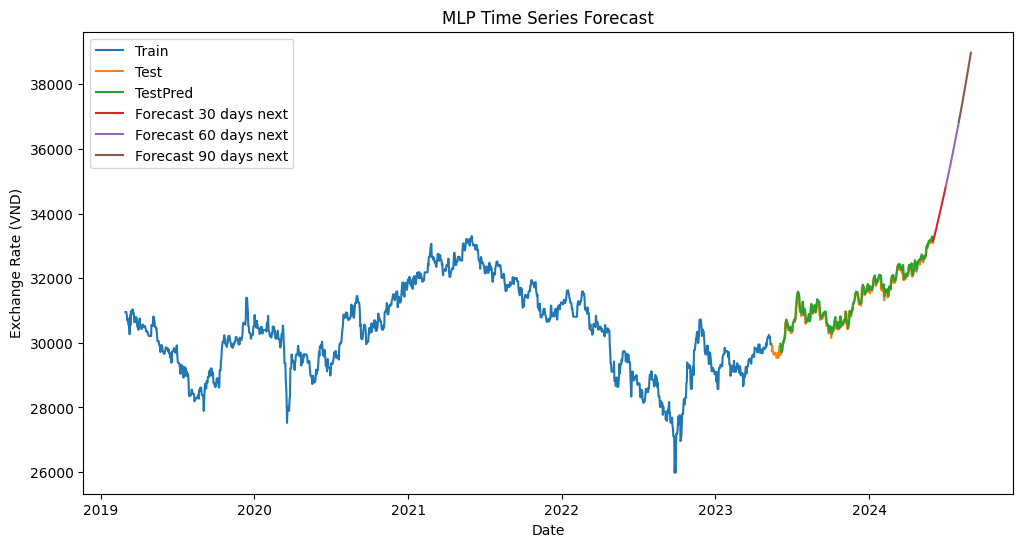

RMSE = 128.46486245507634
MAPE(%) = 0.310507582764971
MAE = 97.16052111950553


In [51]:
implement_MLP(train_gbp_2_sc, test_gbp_2_sc)

- **Case 3. 9:1**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[0.96435934]
21
1 day input [0.91004641 0.93147693 0.95345345 0.94840295 0.94840295 0.94840295
 0.96573847 0.97078897 0.97215397 0.97734098 0.97010647 0.97010647
 0.97010647 0.98321048 0.98948949 0.98826099 0.97229047 0.97147147
 0.97147147 0.96435934]
1 day output [[0.9623486]]
2 day input [0.93147693 0.95345345 0.94840295 0.94840295 0.94840295 0.96573847
 0.97078897 0.97215397 0.97734098 0.97010647 0.97010647 0.97010647
 0.98321048 0.98948949 0.98826099 0.97229047 0.97147147 0.97147147
 0.96435934 0.96234858]
2 day output [[0.9564415]]
3 day input [0.95345345 0.94840295 0.94840295 0.94840295 0.96573847 0.97078897
 0.97215397 0.97734098 0.97010647 0.97010647 0.97010647 0.98321048
 0.98948949 0.98826099 0.97229047 0.97147147 0.97147147 0.96435934
 0.96234858 0.95644152]
3 day output [[0.95404714]]
4 day input [0.94840295 0.94840295 0.94840295 0.96573847 0.97078897 0.97215397
 0.97734098 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949
 0.9882

32 day output [[0.8373941]]
33 day input [0.91047591 0.90758938 0.90300161 0.89902645 0.89524293 0.89054483
 0.88696027 0.88262117 0.8793655  0.87483341 0.87093955 0.86707586
 0.86340606 0.85982585 0.8556847  0.8520689  0.84815532 0.84470081
 0.84086984 0.83739412]
33 day output [[0.83367443]]
34 day input [0.90758938 0.90300161 0.89902645 0.89524293 0.89054483 0.88696027
 0.88262117 0.8793655  0.87483341 0.87093955 0.86707586 0.86340606
 0.85982585 0.8556847  0.8520689  0.84815532 0.84470081 0.84086984
 0.83739412 0.83367443]
34 day output [[0.8300367]]
35 day input [0.90300161 0.89902645 0.89524293 0.89054483 0.88696027 0.88262117
 0.8793655  0.87483341 0.87093955 0.86707586 0.86340606 0.85982585
 0.8556847  0.8520689  0.84815532 0.84470081 0.84086984 0.83739412
 0.83367443 0.8300367 ]
35 day output [[0.82658273]]
36 day input [0.89902645 0.89524293 0.89054483 0.88696027 0.88262117 0.8793655
 0.87483341 0.87093955 0.86707586 0.86340606 0.85982585 0.8556847
 0.8520689  0.84815532 0.84

66 day output [[0.7290647]]
67 day input [0.78596985 0.78280425 0.77956593 0.77642989 0.77329516 0.77017659
 0.76710165 0.76400465 0.76099885 0.75795412 0.75498724 0.75199741
 0.74905795 0.74613243 0.74322575 0.74036062 0.73748988 0.73466843
 0.73184168 0.7290647 ]
67 day output [[0.7262888]]
68 day input [0.78280425 0.77956593 0.77642989 0.77329516 0.77017659 0.76710165
 0.76400465 0.76099885 0.75795412 0.75498724 0.75199741 0.74905795
 0.74613243 0.74322575 0.74036062 0.73748988 0.73466843 0.73184168
 0.7290647  0.7262888 ]
68 day output [[0.7235457]]
69 day input [0.77956593 0.77642989 0.77329516 0.77017659 0.76710165 0.76400465
 0.76099885 0.75795412 0.75498724 0.75199741 0.74905795 0.74613243
 0.74322575 0.74036062 0.73748988 0.73466843 0.73184168 0.7290647
 0.7262888  0.72354567]
69 day output [[0.72081894]]
70 day input [0.77642989 0.77329516 0.77017659 0.76710165 0.76400465 0.76099885
 0.75795412 0.75498724 0.75199741 0.74905795 0.74613243 0.74322575
 0.74036062 0.73748988 0.73

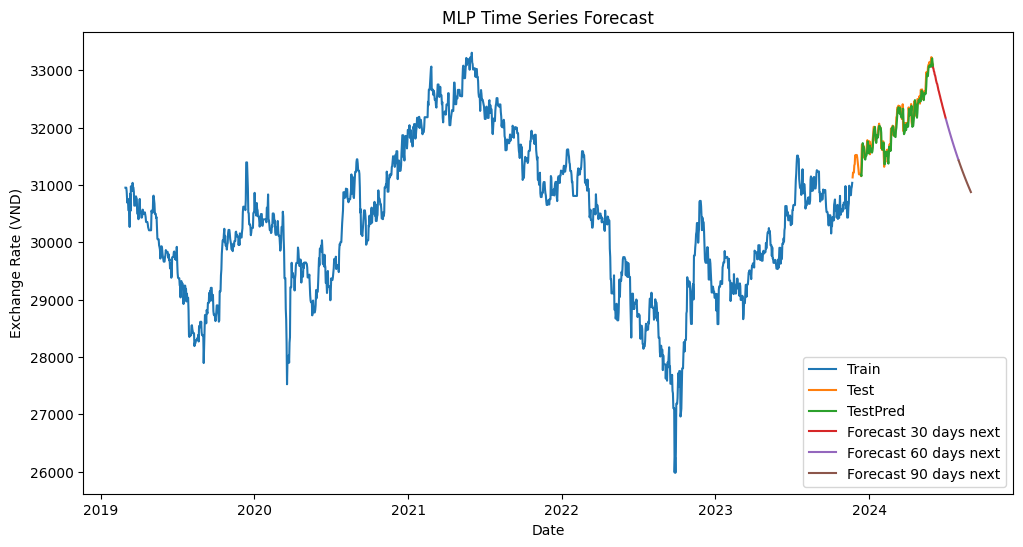

RMSE = 116.82119195952626
MAPE(%) = 0.27745334049138726
MAE = 88.95379496729653


In [52]:
implement_MLP(train_gbp_3_sc, test_gbp_3_sc)

# JPY - VND


In [53]:
# Scale data
jpy_sc = scaler.fit_transform(np.array(jpy).reshape(-1,1))
# Split train, test data
 ## case 1. 7:3
train_jpy_1_sc = jpy_sc[:int(0.7*len(jpy))]
test_jpy_1_sc = jpy_sc[int(0.7*len(jpy)):]
 ## case 2. 8:2
train_jpy_2_sc = jpy_sc[:int(0.8*len(jpy))]
test_jpy_2_sc = jpy_sc[int(0.8*len(jpy)):]
 ## case 3. 9:1
train_jpy_3_sc = jpy_sc[:int(0.9*len(jpy))]
test_jpy_3_sc = jpy_sc[int(0.9*len(jpy)):]

- **Case 1. 7:3**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[0.02025074]
21
1 day input [0.03587444 0.04228059 0.06374119 0.0470852  0.0470852  0.0470852
 0.04788597 0.04003844 0.03619475 0.0318706  0.02674568 0.02674568
 0.02674568 0.02834721 0.02610506 0.02466368 0.02722614 0.02017937
 0.02017937 0.02025074]
1 day output [[0.02243537]]
2 day input [0.04228059 0.06374119 0.0470852  0.0470852  0.0470852  0.04788597
 0.04003844 0.03619475 0.0318706  0.02674568 0.02674568 0.02674568
 0.02834721 0.02610506 0.02466368 0.02722614 0.02017937 0.02017937
 0.02025074 0.02243537]
2 day output [[0.02228858]]
3 day input [0.06374119 0.0470852  0.0470852  0.0470852  0.04788597 0.04003844
 0.03619475 0.0318706  0.02674568 0.02674568 0.02674568 0.02834721
 0.02610506 0.02466368 0.02722614 0.02017937 0.02017937 0.02025074
 0.02243537 0.02228858]
3 day output [[0.02517909]]
4 day input [0.0470852  0.0470852  0.0470852  0.04788597 0.04003844 0.03619475
 0.0318706  0.02674568 0.02674568 0.02674568 0.02834721 0.02610506
 0.0

32 day output [[0.06395645]]
33 day input [0.04481884 0.04732232 0.04776453 0.04854976 0.04927889 0.04948805
 0.04992628 0.05034668 0.05060742 0.05113497 0.05175082 0.05242538
 0.05365701 0.05431838 0.056174   0.05718789 0.05901358 0.06052633
 0.06190794 0.06395645]
33 day output [[0.06534869]]
34 day input [0.04732232 0.04776453 0.04854976 0.04927889 0.04948805 0.04992628
 0.05034668 0.05060742 0.05113497 0.05175082 0.05242538 0.05365701
 0.05431838 0.056174   0.05718789 0.05901358 0.06052633 0.06190794
 0.06395645 0.06534869]
34 day output [[0.06743585]]
35 day input [0.04776453 0.04854976 0.04927889 0.04948805 0.04992628 0.05034668
 0.05060742 0.05113497 0.05175082 0.05242538 0.05365701 0.05431838
 0.056174   0.05718789 0.05901358 0.06052633 0.06190794 0.06395645
 0.06534869 0.06743585]
35 day output [[0.06915978]]
36 day input [0.04854976 0.04927889 0.04948805 0.04992628 0.05034668 0.05060742
 0.05113497 0.05175082 0.05242538 0.05365701 0.05431838 0.056174
 0.05718789 0.05901358 0.

66 day output [[0.11304872]]
67 day input [0.08721127 0.08828679 0.08965076 0.0909013  0.0921189  0.09352297
 0.09473783 0.09613382 0.09746947 0.0988327  0.1002696  0.10166802
 0.1031032  0.10456733 0.10595217 0.10744391 0.1088293  0.11026753
 0.11169747 0.11304872]
67 day output [[0.11449116]]
68 day input [0.08828679 0.08965076 0.0909013  0.0921189  0.09352297 0.09473783
 0.09613382 0.09746947 0.0988327  0.1002696  0.10166802 0.1031032
 0.10456733 0.10595217 0.10744391 0.1088293  0.11026753 0.11169747
 0.11304872 0.11449116]
68 day output [[0.11580654]]
69 day input [0.08965076 0.0909013  0.0921189  0.09352297 0.09473783 0.09613382
 0.09746947 0.0988327  0.1002696  0.10166802 0.1031032  0.10456733
 0.10595217 0.10744391 0.1088293  0.11026753 0.11169747 0.11304872
 0.11449116 0.11580654]
69 day output [[0.11718591]]
70 day input [0.0909013  0.0921189  0.09352297 0.09473783 0.09613382 0.09746947
 0.0988327  0.1002696  0.10166802 0.1031032  0.10456733 0.10595217
 0.10744391 0.1088293  0

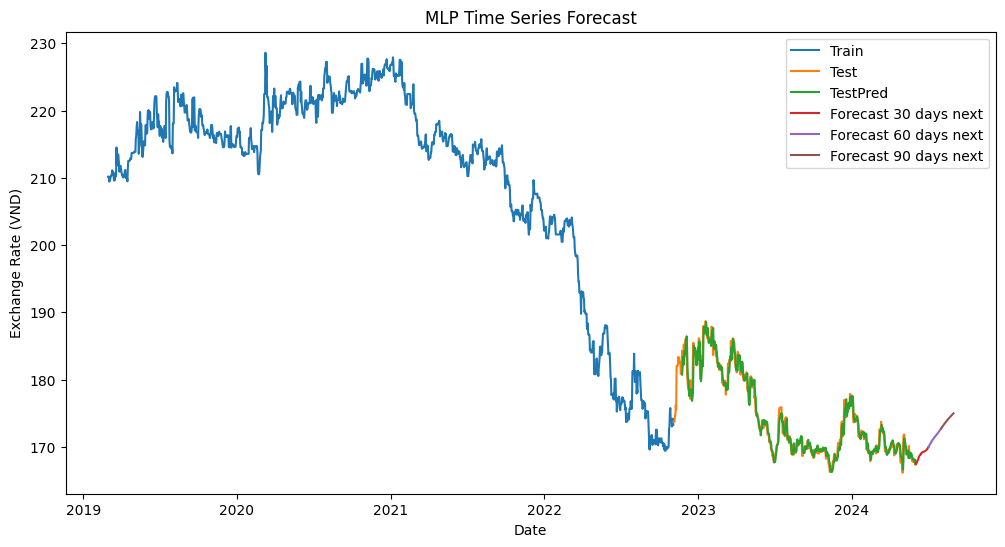

RMSE = 1.092371928317968
MAPE(%) = 0.42026517570683847
MAE = 0.740393709690451


In [54]:
implement_MLP(train_jpy_1_sc, test_jpy_1_sc)

- **Case 2. 8:2**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[0.0203853]
21
1 day input [0.03587444 0.04228059 0.06374119 0.0470852  0.0470852  0.0470852
 0.04788597 0.04003844 0.03619475 0.0318706  0.02674568 0.02674568
 0.02674568 0.02834721 0.02610506 0.02466368 0.02722614 0.02017937
 0.02017937 0.0203853 ]
1 day output [[0.02331845]]
2 day input [0.04228059 0.06374119 0.0470852  0.0470852  0.0470852  0.04788597
 0.04003844 0.03619475 0.0318706  0.02674568 0.02674568 0.02674568
 0.02834721 0.02610506 0.02466368 0.02722614 0.02017937 0.02017937
 0.0203853  0.02331845]
2 day output [[0.02328583]]
3 day input [0.06374119 0.0470852  0.0470852  0.0470852  0.04788597 0.04003844
 0.03619475 0.0318706  0.02674568 0.02674568 0.02674568 0.02834721
 0.02610506 0.02466368 0.02722614 0.02017937 0.02017937 0.0203853
 0.02331845 0.02328583]
3 day output [[0.02542137]]
4 day input [0.0470852  0.0470852  0.0470852  0.04788597 0.04003844 0.03619475
 0.0318706  0.02674568 0.02674568 0.02674568 0.02834721 0.02610506
 0.024

32 day output [[0.06804611]]
33 day input [0.04433798 0.04650681 0.04807074 0.04938661 0.05083337 0.05190914
 0.05328863 0.05437782 0.05550534 0.05654581 0.05793353 0.05883275
 0.06017495 0.06103528 0.06235355 0.06335222 0.0644452  0.06574662
 0.06671612 0.06804611]
33 day output [[0.06907214]]
34 day input [0.04650681 0.04807074 0.04938661 0.05083337 0.05190914 0.05328863
 0.05437782 0.05550534 0.05654581 0.05793353 0.05883275 0.06017495
 0.06103528 0.06235355 0.06335222 0.0644452  0.06574662 0.06671612
 0.06804611 0.06907214]
34 day output [[0.07033063]]
35 day input [0.04807074 0.04938661 0.05083337 0.05190914 0.05328863 0.05437782
 0.05550534 0.05654581 0.05793353 0.05883275 0.06017495 0.06103528
 0.06235355 0.06335222 0.0644452  0.06574662 0.06671612 0.06804611
 0.06907214 0.07033063]
35 day output [[0.07146341]]
36 day input [0.04938661 0.05083337 0.05190914 0.05328863 0.05437782 0.05550534
 0.05654581 0.05793353 0.05883275 0.06017495 0.06103528 0.06235355
 0.06335222 0.0644452  

63 day output [[0.09820285]]
64 day input [0.08123102 0.08231559 0.08324499 0.0842595  0.08520328 0.08613567
 0.08709318 0.08797792 0.088912   0.08978502 0.09068371 0.09154374
 0.09241916 0.09326164 0.09411705 0.09494198 0.09577252 0.09659065
 0.09738967 0.09820285]
64 day output [[0.09897506]]
65 day input [0.08231559 0.08324499 0.0842595  0.08520328 0.08613567 0.08709318
 0.08797792 0.088912   0.08978502 0.09068371 0.09154374 0.09241916
 0.09326164 0.09411705 0.09494198 0.09577252 0.09659065 0.09738967
 0.09820285 0.09897506]
65 day output [[0.09977279]]
66 day input [0.08324499 0.0842595  0.08520328 0.08613567 0.08709318 0.08797792
 0.088912   0.08978502 0.09068371 0.09154374 0.09241916 0.09326164
 0.09411705 0.09494198 0.09577252 0.09659065 0.09738967 0.09820285
 0.09897506 0.09977279]
66 day output [[0.10053091]]
67 day input [0.0842595  0.08520328 0.08613567 0.08709318 0.08797792 0.088912
 0.08978502 0.09068371 0.09154374 0.09241916 0.09326164 0.09411705
 0.09494198 0.09577252 0.

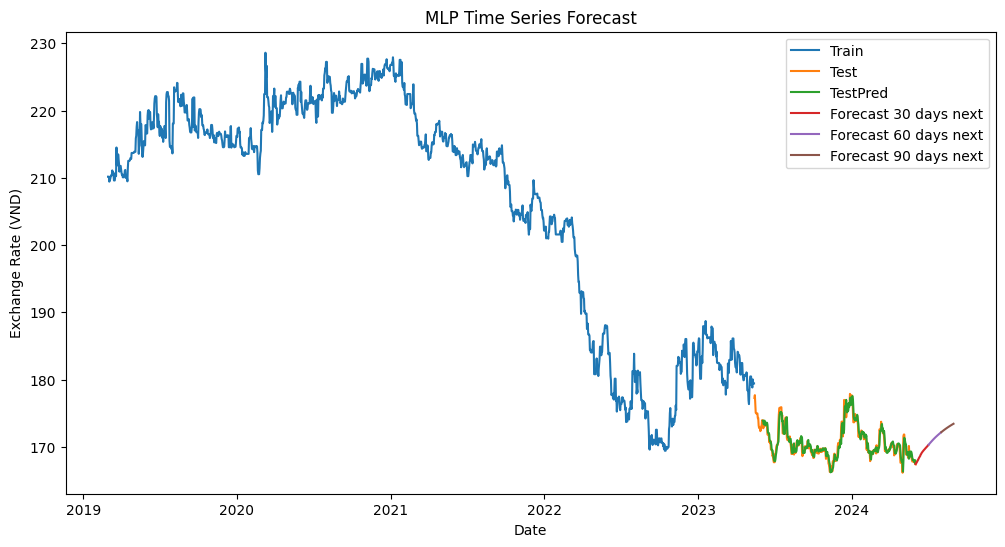

RMSE = 0.8370920565196187
MAPE(%) = 0.3356208329869907
MAE = 0.574509887695313


In [55]:
implement_MLP(train_jpy_2_sc, test_jpy_2_sc)

- **Case 3. 9:1**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
[0.02483506]
21
1 day input [0.03587444 0.04228059 0.06374119 0.0470852  0.0470852  0.0470852
 0.04788597 0.04003844 0.03619475 0.0318706  0.02674568 0.02674568
 0.02674568 0.02834721 0.02610506 0.02466368 0.02722614 0.02017937
 0.02017937 0.02483506]
1 day output [[0.02539264]]
2 day input [0.04228059 0.06374119 0.0470852  0.0470852  0.0470852  0.04788597
 0.04003844 0.03619475 0.0318706  0.02674568 0.02674568 0.02674568
 0.02834721 0.02610506 0.02466368 0.02722614 0.02017937 0.02017937
 0.02483506 0.02539264]
2 day output [[0.02990765]]
3 day input [0.06374119 0.0470852  0.0470852  0.0470852  0.04788597 0.04003844
 0.03619475 0.0318706  0.02674568 0.02674568 0.02674568 0.02834721
 0.02610506 0.02466368 0.02722614 0.02017937 0.02017937 0.02483506
 0.02539264 0.02990765]
3 day output [[0.03644428]]
4 day input [0.0470852  0.0470852  0.0470852  0.04788597 0.04003844 0.03619475
 0.0318706  0.02674568 0.02674568 0.02674568 0.02834721 0.02610506
 0.024

35 day output [[0.18827991]]
36 day input [0.0962548  0.09972859 0.10200779 0.1052153  0.10898461 0.11249694
 0.1172559  0.12219033 0.12726653 0.13231783 0.13747944 0.14296719
 0.14815995 0.15388203 0.1595023  0.16507845 0.17092207 0.17671217
 0.18252935 0.18827991]
36 day output [[0.19398373]]
37 day input [0.09972859 0.10200779 0.1052153  0.10898461 0.11249694 0.1172559
 0.12219033 0.12726653 0.13231783 0.13747944 0.14296719 0.14815995
 0.15388203 0.1595023  0.16507845 0.17092207 0.17671217 0.18252935
 0.18827991 0.19398373]
37 day output [[0.19967933]]
38 day input [0.10200779 0.1052153  0.10898461 0.11249694 0.1172559  0.12219033
 0.12726653 0.13231783 0.13747944 0.14296719 0.14815995 0.15388203
 0.1595023  0.16507845 0.17092207 0.17671217 0.18252935 0.18827991
 0.19398373 0.19967933]
38 day output [[0.20516503]]
39 day input [0.1052153  0.10898461 0.11249694 0.1172559  0.12219033 0.12726653
 0.13231783 0.13747944 0.14296719 0.14815995 0.15388203 0.1595023
 0.16507845 0.17092207 0.

70 day output [[0.34852034]]
71 day input [0.27336934 0.27850932 0.28355432 0.28846663 0.29325247 0.29791829
 0.30246511 0.30686972 0.3111707  0.31532627 0.31934348 0.32322711
 0.32696044 0.3305431  0.33396423 0.33722132 0.3403084  0.34322217
 0.34596497 0.34852034]
71 day output [[0.35088944]]
72 day input [0.27850932 0.28355432 0.28846663 0.29325247 0.29791829 0.30246511
 0.30686972 0.3111707  0.31532627 0.31934348 0.32322711 0.32696044
 0.3305431  0.33396423 0.33722132 0.3403084  0.34322217 0.34596497
 0.34852034 0.35088944]
72 day output [[0.35308507]]
73 day input [0.28355432 0.28846663 0.29325247 0.29791829 0.30246511 0.30686972
 0.3111707  0.31532627 0.31934348 0.32322711 0.32696044 0.3305431
 0.33396423 0.33722132 0.3403084  0.34322217 0.34596497 0.34852034
 0.35088944 0.35308507]
73 day output [[0.35510254]]
74 day input [0.28846663 0.29325247 0.29791829 0.30246511 0.30686972 0.3111707
 0.31532627 0.31934348 0.32322711 0.32696044 0.3305431  0.33396423
 0.33722132 0.3403084  0.

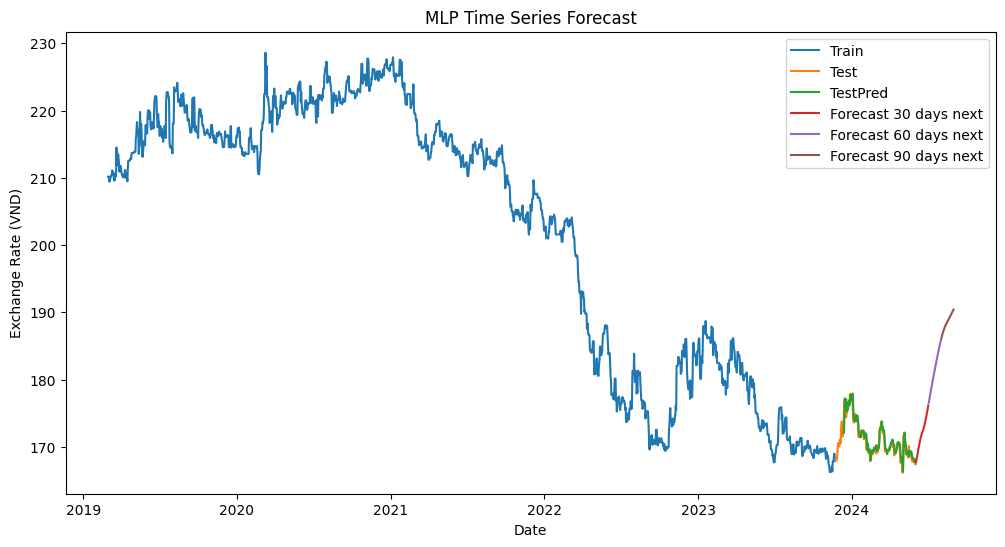

RMSE = 0.8873603338142604
MAPE(%) = 0.36598255958913933
MAE = 0.6270954362736201


In [56]:
implement_MLP(train_jpy_3_sc, test_jpy_3_sc)